# Pixel Coordinate Regression (50×50) using Deep Learning (TensorFlow)

## Problem
Given a 50×50 grayscale image where exactly **one pixel has intensity 255** and all other pixels are 0, predict the **(x, y)** coordinates of the bright pixel.

- **Input:** 50×50 image (grayscale)
- **Output:** coordinates **(x, y)** of the bright pixel
- **Coordinate convention:** `image[y, x] = 255` (0-indexed)


## Why evaluate 3 different Deep Learning models?

The goal of this assignment is to show a strong **approach**, not just accuracy.  
So we compare **three progressively stronger models**:

1. **Model 1 — MLP Regressor (Baseline DL)**
   - Flattens the image and predicts (x, y) using dense layers.
   - Provides a deep-learning baseline with minimal assumptions.

2. **Model 2 — CNN Regressor**
   - Uses convolution layers to learn spatial patterns.
   - Adds inductive bias for images, usually improving localization.

3. **Model 3 — Heatmap Localization + Soft-Argmax (More advanced)**
   - Predicts a probability-like heatmap of the pixel location internally and converts it to (x, y).
   - More interpretable for localization tasks and often more stable.

We select the **best model** using test-set coordinate error (especially **p95 Euclidean distance**).


## Canonical 16-Step Workflow Used in this Notebook

1. Problem Definition & Objective  
2. Dataset Selection / Design  
3. Data Understanding & Exploration (EDA)  
4. Data Preprocessing  
5. Baseline Model  
6. Model Architecture Design  
7. Loss Function & Optimization  
8. Training Strategy  
9. Model Training  
10. Model Evaluation  
11. Error Analysis  
12. Generalization & Robustness Checks  
13. Hyperparameter Tuning  
14. Deployment Considerations  
15. Documentation & Explainability  
16. Conclusion & Future Work


## Dataset Description (TFRecord, 150,000 samples)

- **Dataset folder:** `Pixel_dataset/`
- **Total samples:** 150,000
- **Image shape:** (50, 50), grayscale, dtype `uint8`
- **Label:** coordinates `(x, y)` where:
  - `x = column index`, `y = row index`, both in [0, 49]
  - **Convention:** `image[y, x] = 255`
- **Data storage:** TFRecord shards containing:
  - `image_tensor` (serialized uint8 tensor)
  - `x` and `y` (int64)
- **Splits:** index-based reproducible split files:
  - `split_train_idx.npy` (80%)
  - `split_val_idx.npy` (10%)
  - `split_test_idx.npy` (10%)
- **Metadata:** `meta.json` describing dataset configuration.


## Step 1 — Problem Definition & Objective

We define the task precisely:
- Input: 50×50 grayscale image with exactly one bright pixel (255).
- Output: predict its (x, y) coordinate in pixel units.
- Success metric: Mean Absolute Error (MAE) for x and y, and Euclidean distance error in pixels.

This step ensures all later preprocessing and evaluation are aligned with the same coordinate convention.


## Step 2 — Dataset Selection / Design

We use a synthetic dataset because:
- The task is fully defined and labels are perfect.
- Data can be generated at scale with uniform sampling across all pixel positions.

In this section we:
- Load dataset metadata (image size, bright value, compression).
- Find TFRecord shard files.
- Load train/val/test split indices for reproducible experiments.


In [1]:
import glob
import json
from pathlib import Path

import numpy as np
import tensorflow as tf

DATASET_DIR = Path("Pixel_dataset")  # <-- change if your folder name differs
META_PATH = DATASET_DIR / "meta.json"

if not META_PATH.exists():
    raise FileNotFoundError(f"meta.json not found at: {META_PATH.resolve()}")

print("Dataset dir:", DATASET_DIR.resolve())


Dataset dir: C:\Users\adity\Desktop\DeepEdge\Pixel_dataset


In [2]:
meta = json.loads(META_PATH.read_text(encoding="utf-8"))

IMG_SIZE = int(meta["img_size"])
BRIGHT_VALUE = int(meta["bright_value"])
COMPRESSION = meta.get("compression", "GZIP")  # "GZIP" or ""

tfrecord_files = sorted(glob.glob(str(DATASET_DIR / "*.tfrecord")))
if len(tfrecord_files) == 0:
    raise FileNotFoundError(f"No TFRecord files found in: {DATASET_DIR.resolve()}")

print("IMG_SIZE:", IMG_SIZE)
print("BRIGHT_VALUE:", BRIGHT_VALUE)
print("COMPRESSION:", COMPRESSION)
print("TFRecord shards:", len(tfrecord_files))
print("Example shard:", tfrecord_files[0])


IMG_SIZE: 50
BRIGHT_VALUE: 255
COMPRESSION: GZIP
TFRecord shards: 10
Example shard: Pixel_dataset\data-00000-of-00010.tfrecord


In [3]:
train_idx_path = DATASET_DIR / "split_train_idx.npy"
val_idx_path = DATASET_DIR / "split_val_idx.npy"
test_idx_path = DATASET_DIR / "split_test_idx.npy"

for p in [train_idx_path, val_idx_path, test_idx_path]:
    if not p.exists():
        raise FileNotFoundError(f"Split file not found: {p.resolve()}")

train_idx = np.load(train_idx_path)
val_idx = np.load(val_idx_path)
test_idx = np.load(test_idx_path)

n_train = len(train_idx)
n_val = len(val_idx)
n_test = len(test_idx)

print("Split sizes:")
print("  train:", n_train)
print("  val  :", n_val)
print("  test :", n_test)
print("Total :", n_train + n_val + n_test)


Split sizes:
  train: 120000
  val  : 15000
  test : 15000
Total : 150000


## Step 3 — Data Understanding & Exploration (EDA)

Before preprocessing, we validate the data:
- TFRecord decoding is correct
- Exactly one pixel equals 255
- Label matches the bright pixel location
- Coordinate distribution is approximately uniform (no bias)
- Train/val/test splits do not overlap

This step prevents silent errors that can ruin training and evaluation later.


In [4]:
def parse_example(example_proto, img_size: int):
    """
    Parses one TFRecord example and returns:
      image: uint8 tensor (img_size, img_size)
      x, y : int32 scalars
    """
    feature_spec = {
        "image_tensor": tf.io.FixedLenFeature([], tf.string),
        "x": tf.io.FixedLenFeature([], tf.int64),
        "y": tf.io.FixedLenFeature([], tf.int64),
    }
    ex = tf.io.parse_single_example(example_proto, feature_spec)

    img = tf.io.parse_tensor(ex["image_tensor"], out_type=tf.uint8)
    img = tf.reshape(img, (img_size, img_size))

    x = tf.cast(ex["x"], tf.int32)
    y = tf.cast(ex["y"], tf.int32)
    return img, x, y


raw_ds = tf.data.TFRecordDataset(
    tfrecord_files,
    compression_type=COMPRESSION if COMPRESSION else None
)
print("Raw dataset created.")


Raw dataset created.


In [5]:
def sanity_check_dataset(dataset, img_size: int,
                         bright_value: int, n_checks: int = 50):
    """
    Checks:
      1) Exactly one bright pixel == bright_value
      2) That pixel matches the stored (x,y)
    """
    parsed = dataset.map(lambda r: parse_example(r, img_size))
    checked = 0

    for img, x, y in parsed.take(n_checks):
        img_np = img.numpy()
        x_np = int(x.numpy())
        y_np = int(y.numpy())

        bright_count = int(np.sum(img_np == bright_value))
        if bright_count != 1:
            raise AssertionError(
                f"Expected 1 bright pixel, found {bright_count}")

        if img_np[y_np, x_np] != bright_value:
            raise AssertionError(
                f"Label mismatch: img[y,x] != {bright_value} at ({x_np},{y_np})")

        checked += 1

    print(f"✅ Sanity check passed for {checked} samples")


sanity_check_dataset(raw_ds, IMG_SIZE, BRIGHT_VALUE, n_checks=50)


✅ Sanity check passed for 50 samples


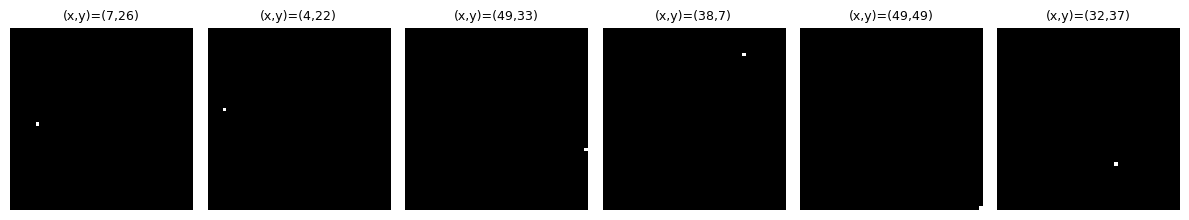

In [6]:
import matplotlib.pyplot as plt


def show_samples(dataset, img_size: int, n: int = 6):
    parsed = dataset.map(lambda r: parse_example(r, img_size))
    samples = list(parsed.take(n))

    plt.figure(figsize=(12, 4))
    for i, (img, x, y) in enumerate(samples, start=1):
        plt.subplot(1, n, i)
        plt.imshow(img.numpy(), cmap="gray", vmin=0, vmax=255)
        plt.title(f"(x,y)=({int(x.numpy())},{int(y.numpy())})", fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


show_samples(raw_ds, IMG_SIZE, n=6)


In [7]:
def collect_labels(dataset, img_size: int, max_samples: int = 10_000):
    parsed = dataset.map(lambda r: parse_example(r, img_size))
    xs, ys = [], []
    for img, x, y in parsed.take(max_samples):
        xs.append(int(x.numpy()))
        ys.append(int(y.numpy()))
    return np.array(xs), np.array(ys)


xs, ys = collect_labels(raw_ds, IMG_SIZE, max_samples=10_000)

print("x range:", xs.min(), xs.max())
print("y range:", ys.min(), ys.max())
print("Unique x:", len(np.unique(xs)), "Unique y:", len(np.unique(ys)))


x range: 0 49
y range: 0 49
Unique x: 50 Unique y: 50


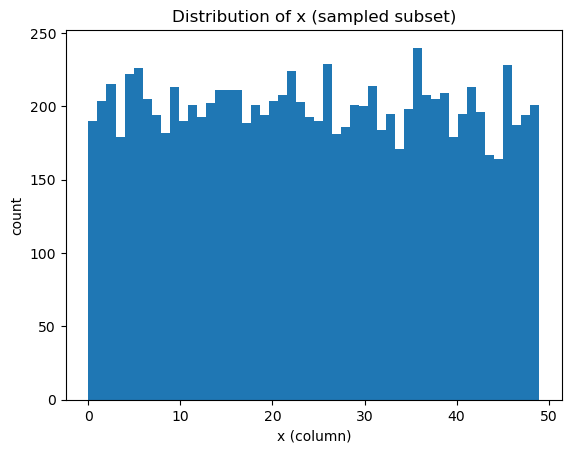

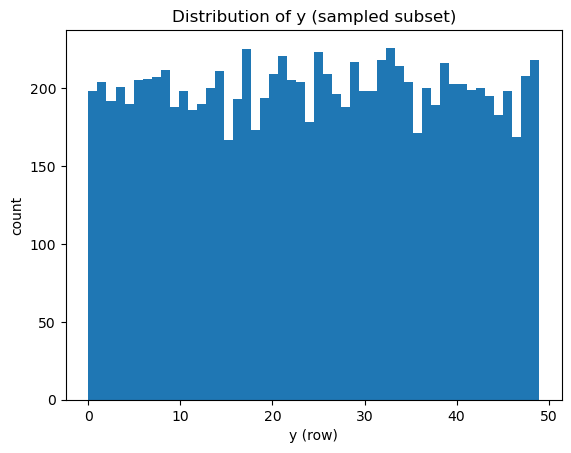

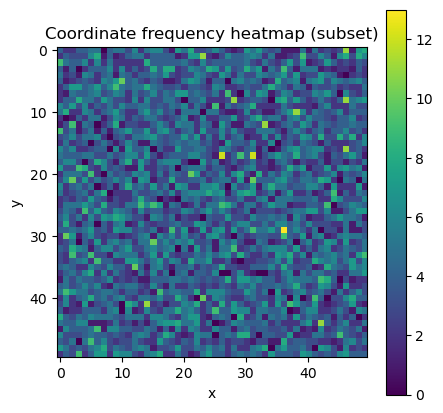

In [8]:
plt.figure()
plt.hist(xs, bins=IMG_SIZE)
plt.title("Distribution of x (sampled subset)")
plt.xlabel("x (column)")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(ys, bins=IMG_SIZE)
plt.title("Distribution of y (sampled subset)")
plt.xlabel("y (row)")
plt.ylabel("count")
plt.show()

# 2D frequency heatmap (subset)
heat = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.int32)
for x, y in zip(xs, ys):
    heat[y, x] += 1

plt.figure(figsize=(5, 5))
plt.imshow(heat, cmap="viridis")
plt.title("Coordinate frequency heatmap (subset)")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()


In [9]:
train_set = set(train_idx.tolist())
val_set = set(val_idx.tolist())
test_set = set(test_idx.tolist())

overlap_tv = len(train_set.intersection(val_set))
overlap_tt = len(train_set.intersection(test_set))
overlap_vt = len(val_set.intersection(test_set))

print("Overlap checks (should all be 0):")
print("train ∩ val :", overlap_tv)
print("train ∩ test:", overlap_tt)
print("val   ∩ test:", overlap_vt)


Overlap checks (should all be 0):
train ∩ val : 0
train ∩ test: 0
val   ∩ test: 0


## Step 4 — Data Preprocessing (Normalization + Shapes)

We build tf.data pipelines that:
- Decode TFRecords
- Normalize images from uint8 to float32 in [0, 1]
- Add channel dimension (50, 50, 1)

We produce two label formats:
- Regression labels: (x, y)
- Heatmap labels: (50, 50, 1) one-hot map (for Model 3)

We use split index arrays to filter records into:
- training set (repeat=True for stable multi-epoch training)
- validation set
- test set

We also compute:
- STEPS_PER_EPOCH
- VAL_STEPS
- TEST_STEPS

These are required because repeated datasets need explicit step counts.

In [10]:
def preprocess_for_regression(img_u8, x, y, img_size: int):
    """
    Returns:
      image_f32: (img_size, img_size, 1) float32 in [0,1]
      target_xy: (2,) float32 -> [x, y] in pixel units
    """
    img = tf.cast(img_u8, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=-1)  # (H,W,1)

    target_xy = tf.stack(
        [tf.cast(x, tf.float32), tf.cast(y, tf.float32)], axis=0)
    return img, target_xy


def preprocess_for_heatmap(img_u8, x, y, img_size: int):
    """
    Returns:
      image_f32: (img_size, img_size, 1) float32 in [0,1]
      heatmap  : (img_size, img_size, 1) float32 one-hot at [y,x]
    """
    img = tf.cast(img_u8, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=-1)

    idx = tf.stack([y, x], axis=0)  # [row, col]
    heat = tf.scatter_nd(
        indices=[idx],
        updates=[1.0],
        shape=(
            img_size,
            img_size))
    heat = tf.expand_dims(heat, axis=-1)
    return img, heat


In [11]:
def augment_image(image, target):
    """
    Mild augmentation: small gaussian noise to simulate sensor noise.
    Keep it small so we don't break the "single bright pixel" nature.
    """
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.01)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)
    return image, target


In [12]:
def build_index_lookup(indices: np.ndarray) -> tf.lookup.StaticHashTable:
    """
    Creates a lookup table for membership checks of indices.
    """
    keys = tf.constant(indices.astype(np.int64))
    vals = tf.ones_like(keys, dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        initializer=tf.lookup.KeyValueTensorInitializer(keys, vals),
        default_value=0,
    )
    return table


def make_split_dataset(
    tfrecord_files,
    split_indices: np.ndarray,
    img_size: int,
    compression: str,
    mode: str = "regression",          # "regression" or "heatmap"
    batch_size: int = 128,
    shuffle: bool = False,
    augment: bool = False,
    repeat: bool = False,              # ✅ key fix
    shuffle_buffer: int = 20_000,
):
    """
    Builds a tf.data.Dataset for a given split using split_indices.

    mode:
      - "regression": returns (image, [x,y])
      - "heatmap": returns (image, heatmap)

    repeat:
      - True for training dataset (infinite), paired with steps_per_epoch in model.fit()
    """
    table = build_index_lookup(split_indices)

    ds = tf.data.TFRecordDataset(
        tfrecord_files,
        compression_type=compression if compression else None
    )

    # enumerate to attach global record index
    ds = ds.enumerate()  # (idx, record)

    def _keep(idx, record):
        return table.lookup(idx) > 0

    ds = ds.filter(_keep)

    def _parse_and_preprocess(idx, record):
        img_u8, x, y = parse_example(record, img_size)  # from Step 3
        if mode == "regression":
            return preprocess_for_regression(img_u8, x, y, img_size)
        if mode == "heatmap":
            return preprocess_for_heatmap(img_u8, x, y, img_size)
        raise ValueError("mode must be 'regression' or 'heatmap'")

    ds = ds.map(_parse_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(
            buffer_size=shuffle_buffer,
            reshuffle_each_iteration=True)

    if repeat:  # ✅ prevents "ran out of data"
        ds = ds.repeat()

    if augment:
        ds = ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


In [13]:
import math

BATCH_SIZE = 128

# Regression datasets (Model 1 & 2)
train_ds_reg = make_split_dataset(
    tfrecord_files, train_idx, IMG_SIZE, COMPRESSION,
    mode="regression",
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=False,
    repeat=True,         # ✅ repeat only for training
)

val_ds_reg = make_split_dataset(
    tfrecord_files, val_idx, IMG_SIZE, COMPRESSION,
    mode="regression",
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment=False,
    repeat=False,
)

test_ds_reg = make_split_dataset(
    tfrecord_files, test_idx, IMG_SIZE, COMPRESSION,
    mode="regression",
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment=False,
    repeat=False,
)

# Heatmap datasets (Model 3)
train_ds_heat = make_split_dataset(
    tfrecord_files, train_idx, IMG_SIZE, COMPRESSION,
    mode="heatmap",
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=False,
    repeat=True,        # ✅ repeat only for training
)

val_ds_heat = make_split_dataset(
    tfrecord_files, val_idx, IMG_SIZE, COMPRESSION,
    mode="heatmap",
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment=False,
    repeat=False,
)

test_ds_heat = make_split_dataset(
    tfrecord_files, test_idx, IMG_SIZE, COMPRESSION,
    mode="heatmap",
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment=False,
    repeat=False,
)

# steps for fit() when train ds repeats
STEPS_PER_EPOCH = math.ceil(len(train_idx) / BATCH_SIZE)
VAL_STEPS = math.ceil(len(val_idx) / BATCH_SIZE)
TEST_STEPS = math.ceil(len(test_idx) / BATCH_SIZE)

print("Datasets ready ✅")
print(
    "STEPS_PER_EPOCH:",
    STEPS_PER_EPOCH,
    "VAL_STEPS:",
    VAL_STEPS,
    "TEST_STEPS:",
    TEST_STEPS)


Datasets ready ✅
STEPS_PER_EPOCH: 938 VAL_STEPS: 118 TEST_STEPS: 118


In [14]:
xb, yb = next(iter(train_ds_reg))
print("Regression shapes:", xb.shape, yb.shape, xb.dtype, yb.dtype)

xbh, ybh = next(iter(train_ds_heat))
print("Heatmap shapes   :", xbh.shape, ybh.shape, xbh.dtype, ybh.dtype)


Regression shapes: (128, 50, 50, 1) (128, 2) <dtype: 'float32'> <dtype: 'float32'>
Heatmap shapes   : (128, 50, 50, 1) (128, 50, 50, 1) <dtype: 'float32'> <dtype: 'float32'>


## Step 5 — Baseline Model (Model 1: MLP Regressor)

We train the first deep learning baseline:
- Flatten image → Dense layers → predict (x, y)

Why this baseline:
- Establishes a performance floor
- Validates that our pipeline and labels are correct
- Avoids jumping to complex models too early

We also create reusable utilities:
- training curve plotting
- ground-truth vs predicted plots
- evaluation stats (mean/median/p95 distance error)

We train the MLP using:
- Early stopping
- LR reduction on plateau
- Explicit steps_per_epoch due to dataset repeat()

We evaluate on the test split and store results for later comparison.

In [15]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers


def euclidean_distance_error(y_true, y_pred):
    diff = y_true - y_pred
    dist = tf.sqrt(tf.reduce_sum(tf.square(diff), axis=-1))
    return tf.reduce_mean(dist)


def plot_history(hist, title_prefix="Model"):
    plt.figure()
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.title(f"{title_prefix} - Loss (MSE)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    if "euclidean_distance_error" in hist.history:
        plt.figure()
        plt.plot(hist.history["euclidean_distance_error"], label="train_dist")
        plt.plot(
            hist.history["val_euclidean_distance_error"],
            label="val_dist")
        plt.title(f"{title_prefix} - Euclidean Distance Error (pixels)")
        plt.xlabel("Epoch")
        plt.ylabel("Distance Error")
        plt.legend()
        plt.show()


def evaluate_regression_model(model, dataset, steps: int, name="model"):
    y_true_all, y_pred_all = [], []

    it = iter(dataset)
    for _ in range(steps):
        x_batch, y_batch = next(it)
        y_pred = model.predict(x_batch, verbose=0)
        y_true_all.append(y_batch.numpy())
        y_pred_all.append(y_pred)

    y_true_all = np.vstack(y_true_all)
    y_pred_all = np.vstack(y_pred_all)

    mae_x = float(np.mean(np.abs(y_true_all[:, 0] - y_pred_all[:, 0])))
    mae_y = float(np.mean(np.abs(y_true_all[:, 1] - y_pred_all[:, 1])))
    dist = np.sqrt(np.sum((y_true_all - y_pred_all) ** 2, axis=1))

    results = {
        "name": name,
        "mae_x": mae_x,
        "mae_y": mae_y,
        "dist_mean": float(np.mean(dist)),
        "dist_median": float(np.median(dist)),
        "dist_p90": float(np.percentile(dist, 90)),
        "dist_p95": float(np.percentile(dist, 95)),
    }
    return results, y_true_all, y_pred_all, dist


def plot_gt_vs_pred(y_true, y_pred, title="GT vs Pred"):
    plt.figure()
    plt.scatter(y_true[:, 0], y_pred[:, 0], s=5)
    plt.title(f"{title} (x)")
    plt.xlabel("x_true")
    plt.ylabel("x_pred")
    plt.show()

    plt.figure()
    plt.scatter(y_true[:, 1], y_pred[:, 1], s=5)
    plt.title(f"{title} (y)")
    plt.xlabel("y_true")
    plt.ylabel("y_pred")
    plt.show()

    dist = np.sqrt(np.sum((y_true - y_pred) ** 2, axis=1))
    plt.figure()
    plt.hist(dist, bins=50)
    plt.title(f"{title} - Distance Error Histogram")
    plt.xlabel("Euclidean distance error (pixels)")
    plt.ylabel("count")
    plt.show()


In [16]:
def build_mlp_regressor(img_size: int = 50) -> keras.Model:
    inputs = keras.Input(shape=(img_size, img_size, 1))
    x = layers.Flatten()(inputs)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(2, activation="linear")(x)  # [x,y]
    return keras.Model(inputs, outputs, name="MLP_Regressor")


mlp_model = build_mlp_regressor(IMG_SIZE)
mlp_model.summary()


Model: "MLP_Regressor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 50, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       640,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 681,538 (2.60 MB)

 Trainable params: 681,538 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
mlp_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[euclidean_distance_error],
)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2),
]


In [18]:
history_mlp = mlp_model.fit(
    train_ds_reg,
    validation_data=val_ds_reg,
    epochs=20,
    steps_per_epoch=STEPS_PER_EPOCH,  # ✅ required because train dataset repeats
    validation_steps=VAL_STEPS,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - euclidean_distance_error: 14.5061 - loss: 208.2765 - val_euclidean_distance_error: 0.2587 - val_loss: 0.1446 - learning_rate: 0.0010
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - euclidean_distance_error: 0.3542 - loss: 0.2300 - val_euclidean_distance_error: 0.4451 - val_loss: 0.2804 - learning_rate: 0.0010
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - euclidean_distance_error: 0.4846 - loss: 0.3191 - val_euclidean_distance_error: 0.5646 - val_loss: 0.3310 - learning_rate: 0.0010
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - euclidean_distance_error: 0.1128 - loss: 0.0457 - val_euclidean_distance_error: 0.0012 - val_loss: 1.5544e-04 - learning_rate: 5.0000e-04
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - euclidean_distance_error: 0.0091 - loss: 0.0017 - val_euclidean_distance_error: 0.4766 - val_loss: 0.2293 - learning_rate: 5.0000e-04
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step -

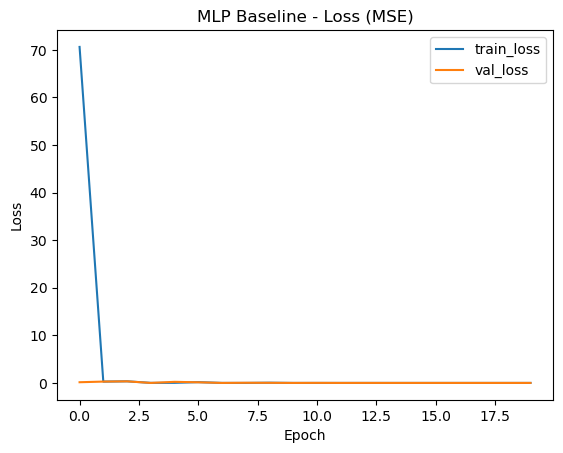

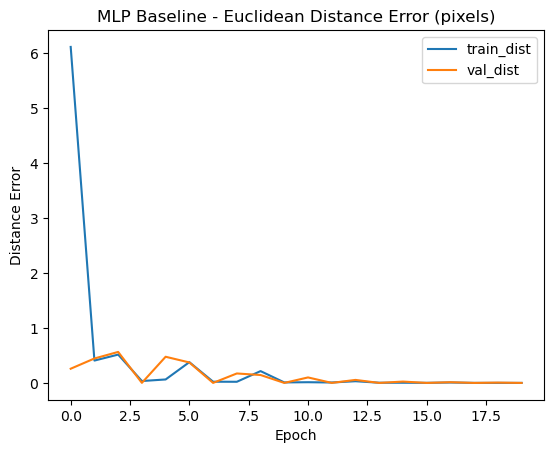

{'name': 'MLP Baseline', 'mae_x': 3.762784035643563e-05, 'mae_y': 4.3898646254092455e-05, 'dist_mean': 6.109819514676929e-05, 'dist_median': 2.0044008124386892e-05, 'dist_p90': 5.670955215464346e-05, 'dist_p95': 8.50806973176077e-05}


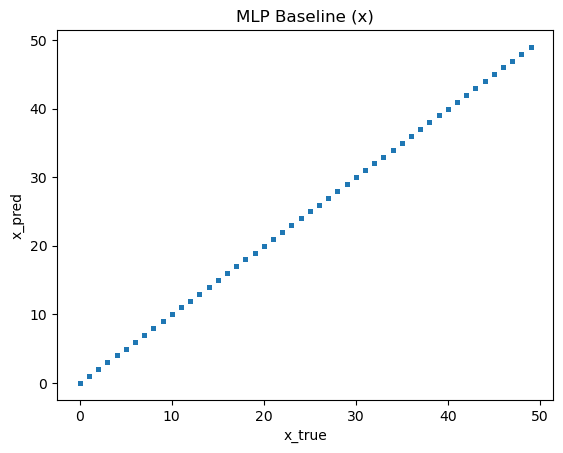

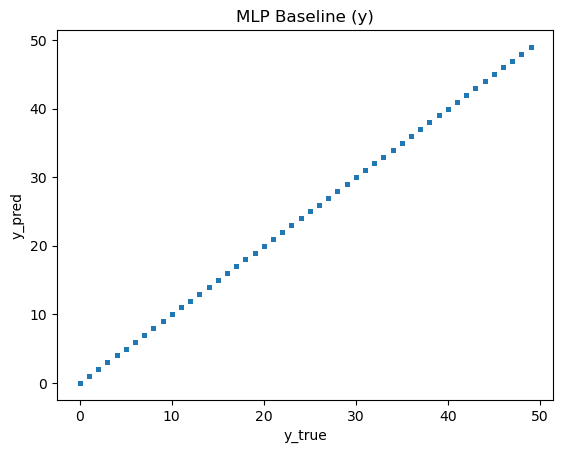

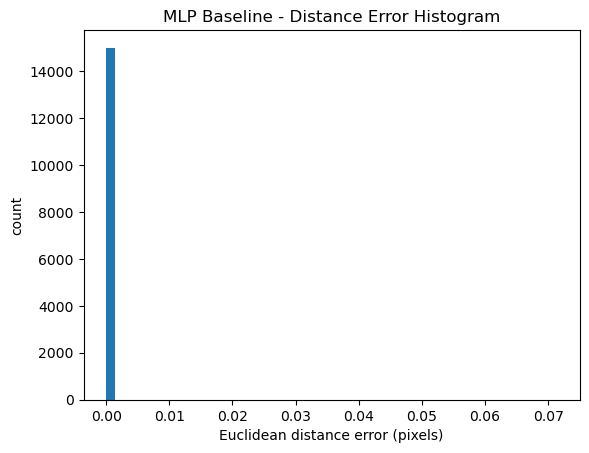

In [19]:
plot_history(history_mlp, title_prefix="MLP Baseline")

mlp_results, mlp_y_true, mlp_y_pred, mlp_dist = evaluate_regression_model(
    mlp_model, test_ds_reg, steps=TEST_STEPS, name="MLP Baseline"
)

print(mlp_results)
plot_gt_vs_pred(mlp_y_true, mlp_y_pred, title="MLP Baseline")


## Step 6 — Model Architecture Design (Models 2 and 3)

We define two additional architectures:

**Model 2: CNN Regressor**
- Convolutions learn spatial patterns
- Outputs (x, y) directly

**Model 3: Heatmap Localization + Soft-Argmax**
- Internally predicts a heatmap of pixel location
- Converts heatmap to coordinates using soft-argmax
- More interpretable localization approach

No training happens here—only model definitions.


In [20]:
from tensorflow import keras
from tensorflow.keras import layers


def build_cnn_regressor(img_size: int = 50) -> keras.Model:
    inputs = keras.Input(shape=(img_size, img_size, 1))

    x = layers.Conv2D(16, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(2, activation="linear")(x)  # [x,y] in pixel units
    return keras.Model(inputs, outputs, name="CNN_Regressor")


cnn_model = build_cnn_regressor(IMG_SIZE)
cnn_model.summary()


Model: "CNN_Regressor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 50, 50, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,874 (124.51 KB)

 Trainable params: 31,874 (124.51 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
class SoftArgmax2D(keras.layers.Layer):
    """
    Converts a (H,W,1) heatmap into (x,y) coordinates using soft-argmax.
    Output is in pixel coordinates: x in [0, W-1], y in [0, H-1]
    """

    def __init__(self, temperature: float = 1.0, **kwargs):
        super().__init__(**kwargs)
        self.temperature = temperature

    def call(self, heatmap):
        # heatmap: (B,H,W,1)
        heatmap = tf.squeeze(heatmap, axis=-1)  # (B,H,W)
        b = tf.shape(heatmap)[0]
        h = tf.shape(heatmap)[1]
        w = tf.shape(heatmap)[2]

        # Flatten
        flat = tf.reshape(heatmap, (b, h * w))

        # Softmax over pixels (temperature controls sharpness)
        probs = tf.nn.softmax(flat / self.temperature, axis=-1)  # (B, H*W)

        # Create coordinate grids
        xs = tf.range(w, dtype=tf.float32)
        ys = tf.range(h, dtype=tf.float32)
        x_grid, y_grid = tf.meshgrid(xs, ys)  # (H,W)

        x_grid = tf.reshape(x_grid, (h * w,))  # (H*W,)
        y_grid = tf.reshape(y_grid, (h * w,))  # (H*W,)

        # Expected coordinates
        x = tf.reduce_sum(probs * x_grid[None, :], axis=-1)
        y = tf.reduce_sum(probs * y_grid[None, :], axis=-1)

        coords = tf.stack([x, y], axis=-1)  # (B,2) -> [x,y]
        return coords


In [22]:
def build_heatmap_softargmax_model(
        img_size: int = 50, temperature: float = 0.5) -> keras.Model:
    inputs = keras.Input(shape=(img_size, img_size, 1))

    x = layers.Conv2D(16, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.UpSampling2D()(x)  # back to original resolution

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)

    # 1-channel heatmap logits
    heat_logits = layers.Conv2D(
        1,
        1,
        padding="same",
        activation=None,
        name="heat_logits")(x)

    # Convert logits -> probability-like heatmap using softmax across pixels
    # We'll use a custom layer-like operation: flatten -> softmax -> reshape
    def spatial_softmax(hm):
        b = tf.shape(hm)[0]
        h = tf.shape(hm)[1]
        w = tf.shape(hm)[2]
        hm = tf.reshape(hm, (b, h * w))
        hm = tf.nn.softmax(hm, axis=-1)
        return tf.reshape(hm, (b, h, w, 1))

    heatmap = layers.Lambda(spatial_softmax, name="heatmap")(heat_logits)

    coords = SoftArgmax2D(temperature=temperature, name="softargmax")(heatmap)

    return keras.Model(inputs, outputs={
                       "softargmax": coords, "heatmap": heatmap}, name="Heatmap_SoftArgmax")


heatmap_model = build_heatmap_softargmax_model(IMG_SIZE, temperature=0.5)
heatmap_model.summary()


Model: "Heatmap_SoftArgmax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 50, 50, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ heat_logits (Conv2D)            │ (None, 50, 50, 1)      │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ heatmap (Lambda)                │ (None, 50, 50, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softargmax (SoftArgmax2D)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,081 (55.00 KB)

 Trainable params: 14,081 (55.00 KB)

 Non-trainable params: 0 (0.00 B)

## Step 7 — Loss Functions & Optimization

We choose losses based on outputs:

- Model 1 & Model 2 (coordinate regression):
  - Loss: Mean Squared Error (MSE) on (x, y)
  - Metric: Euclidean distance error in pixels

- Model 3 (coords-only training using heatmap labels):
  - True coords are derived from the one-hot heatmap label
  - Loss: MSE between true coords and predicted coords
  - Metric: Euclidean distance error

We use Adam optimizer with a stable learning rate (e.g., 1e-3).


In [23]:
import tensorflow as tf
from tensorflow import keras


def euclidean_distance_error(y_true, y_pred):
    diff = y_true - y_pred
    dist = tf.sqrt(tf.reduce_sum(tf.square(diff), axis=-1))
    return tf.reduce_mean(dist)


In [24]:
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[euclidean_distance_error],
)


In [25]:
def heatmap_cross_entropy(y_true_heat, y_pred_heat, eps: float = 1e-7):
    """
    y_true_heat: (B,H,W,1) one-hot
    y_pred_heat: (B,H,W,1) prob-like (sums to 1 over pixels)
    Returns mean cross-entropy over batch.
    """
    y_true = tf.reshape(y_true_heat, (tf.shape(y_true_heat)[0], -1))
    y_pred = tf.reshape(y_pred_heat, (tf.shape(y_pred_heat)[0], -1))
    y_pred = tf.clip_by_value(y_pred, eps, 1.0)
    # Since y_true is one-hot, CE = -log(prob at true pixel)
    ce = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
    return tf.reduce_mean(ce)


def coords_from_heatmap(y_true_heat):
    """
    Converts true one-hot heatmap (B,H,W,1) to (B,2) coords [x,y].
    """
    heat = tf.squeeze(y_true_heat, axis=-1)  # (B,H,W)
    b = tf.shape(heat)[0]
    h = tf.shape(heat)[1]
    w = tf.shape(heat)[2]

    flat = tf.reshape(heat, (b, h * w))  # one-hot
    idx = tf.argmax(flat, axis=-1, output_type=tf.int32)  # (B,)
    y = idx // w
    x = idx % w
    return tf.stack([tf.cast(x, tf.float32), tf.cast(y, tf.float32)], axis=-1)


def coord_mse_from_heatmap(y_true_heat, y_pred_coords):
    """
    y_true_heat: (B,H,W,1) one-hot
    y_pred_coords: (B,2) float [x,y]
    """
    y_true_coords = coords_from_heatmap(y_true_heat)
    return tf.reduce_mean(tf.square(y_true_coords - y_pred_coords))


In [26]:
def coords_from_heatmap(y_true_heat):
    """Convert one-hot heatmap (B,H,W,1) -> coords (B,2) [x,y]."""
    heat = tf.squeeze(y_true_heat, axis=-1)  # (B,H,W)
    b = tf.shape(heat)[0]
    h = tf.shape(heat)[1]
    w = tf.shape(heat)[2]
    flat = tf.reshape(heat, (b, h * w))
    idx = tf.argmax(flat, axis=-1, output_type=tf.int32)
    y = idx // w
    x = idx % w
    return tf.stack([tf.cast(x, tf.float32), tf.cast(y, tf.float32)], axis=-1)


def coord_mse_from_heatmap(y_true_heat, y_pred_coords):
    """Loss: MSE(true_coords_from_heatmap, predicted_coords)."""
    y_true_coords = coords_from_heatmap(y_true_heat)
    return tf.reduce_mean(tf.square(y_true_coords - y_pred_coords))


def euclidean_distance_from_heatmap_label(y_true_heat, y_pred_coords):
    """Metric: mean Euclidean distance in pixels."""
    y_true_coords = coords_from_heatmap(y_true_heat)
    diff = y_true_coords - y_pred_coords
    dist = tf.sqrt(tf.reduce_sum(tf.square(diff), axis=-1))
    return tf.reduce_mean(dist)


print("Model 3 output names:", heatmap_model.output_names)

losses = {
    "heatmap": heatmap_cross_entropy,
    "softargmax": coord_mse_from_heatmap
}

loss_weights = {
    "heatmap": 1.0,
    "softargmax": 0.1
}

metrics = {
    "heatmap": [],
    "softargmax": [euclidean_distance_from_heatmap_label]
}

heatmap_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=losses,
    loss_weights=loss_weights,
    metrics=metrics,
)

print("✅ Model 3 re-compiled with self-contained definitions.")


Model 3 output names: ListWrapper(['heatmap', 'softargmax'])
✅ Model 3 re-compiled with self-contained definitions.


## Step 8 — Training Strategy (Fair Comparison)

To compare models fairly:
- Same train/val/test splits
- Same batch size
- Same steps_per_epoch and validation_steps
- Same early stopping and LR scheduling callbacks
- Checkpoint saving for best validation performance

We rebuild datasets with repeat=True only for training, ensuring training never runs out of data.


In [27]:
import math
from pathlib import Path
from tensorflow import keras
import tensorflow as tf

# ======================
# Training configuration
# ======================
EPOCHS = 20
BATCH_SIZE = 128

# Because train datasets are repeated, we must define steps explicitly
STEPS_PER_EPOCH = math.ceil(len(train_idx) / BATCH_SIZE)
VAL_STEPS = math.ceil(len(val_idx) / BATCH_SIZE)
TEST_STEPS = math.ceil(len(test_idx) / BATCH_SIZE)

print("EPOCHS:", EPOCHS)
print("BATCH_SIZE:", BATCH_SIZE)
print("STEPS_PER_EPOCH:", STEPS_PER_EPOCH)
print("VAL_STEPS:", VAL_STEPS)
print("TEST_STEPS:", TEST_STEPS)


EPOCHS: 20
BATCH_SIZE: 128
STEPS_PER_EPOCH: 938
VAL_STEPS: 118
TEST_STEPS: 118


In [28]:
# Rebuild split datasets to ensure repeat settings and batch size are correct
train_ds_reg = make_split_dataset(
    tfrecord_files, train_idx, IMG_SIZE, COMPRESSION,
    mode="regression",
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=False,
    repeat=True,          # ✅ key fix for training
)

val_ds_reg = make_split_dataset(
    tfrecord_files, val_idx, IMG_SIZE, COMPRESSION,
    mode="regression",
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment=False,
    repeat=False,
)

test_ds_reg = make_split_dataset(
    tfrecord_files, test_idx, IMG_SIZE, COMPRESSION,
    mode="regression",
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment=False,
    repeat=False,
)

train_ds_heat = make_split_dataset(
    tfrecord_files, train_idx, IMG_SIZE, COMPRESSION,
    mode="heatmap",
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=False,
    repeat=True,          # ✅ key fix for training
)

val_ds_heat = make_split_dataset(
    tfrecord_files, val_idx, IMG_SIZE, COMPRESSION,
    mode="heatmap",
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment=False,
    repeat=False,
)

test_ds_heat = make_split_dataset(
    tfrecord_files, test_idx, IMG_SIZE, COMPRESSION,
    mode="heatmap",
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment=False,
    repeat=False,
)

print("Datasets rebuilt ✅")


Datasets rebuilt ✅


In [29]:

import tensorflow as tf

# Define output names as constants
HEAT_OUT = "heatmap"
COORD_OUT = "softargmax"


def wrap_heatmap_for_model3_dict(ds):
    return ds.map(
        lambda img, hm: (img, {HEAT_OUT: hm, COORD_OUT: hm}),
        num_parallel_calls=tf.data.AUTOTUNE
    )


train_ds_m3 = wrap_heatmap_for_model3_dict(train_ds_heat)
val_ds_m3 = wrap_heatmap_for_model3_dict(val_ds_heat)
test_ds_m3 = wrap_heatmap_for_model3_dict(test_ds_heat)

print(f"✅ Model 3 datasets wrapped as DICT labels ({HEAT_OUT}, {COORD_OUT})")


✅ Model 3 datasets wrapped as DICT labels (heatmap, softargmax)


In [30]:
CHECKPOINT_DIR = Path("checkpoints")
CHECKPOINT_DIR.mkdir(exist_ok=True)

common_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2
    )
]


def make_checkpoint_callback(model_name: str):
    return keras.callbacks.ModelCheckpoint(
        filepath=str(CHECKPOINT_DIR / f"{model_name}.keras"),
        monitor="val_loss",
        save_best_only=True
    )


mlp_callbacks = common_callbacks + [make_checkpoint_callback("mlp_model")]
cnn_callbacks = common_callbacks + [make_checkpoint_callback("cnn_model")]
m3_callbacks = common_callbacks + [make_checkpoint_callback("heatmap_model")]

print("Callbacks ready ✅")


Callbacks ready ✅


In [31]:

# Check Model 3 dataset dict format
xb3, yb3 = next(iter(train_ds_m3))
print("Model 3 X:", xb3.shape, xb3.dtype)
print("Model 3 y keys:", yb3.keys())
print("Model 3 heatmap label:", yb3["heatmap"].shape, yb3["heatmap"].dtype)
print(
    "Model 3 coord label passed:",
    yb3["softargmax"].shape,
    yb3["softargmax"].dtype)


Model 3 X: (128, 50, 50, 1) <dtype: 'float32'>
Model 3 y keys: dict_keys(['heatmap', 'softargmax'])
Model 3 heatmap label: (128, 50, 50, 1) <dtype: 'float32'>
Model 3 coord label passed: (128, 50, 50, 1) <dtype: 'float32'>


## Step 9 — Train Model 2 (CNN Regressor)

We train the CNN regression model using:
- train_ds_reg and val_ds_reg
- explicit steps_per_epoch and validation_steps
- callbacks (early stopping, LR scheduler, checkpoint)

This model should outperform the MLP because CNNs preserve spatial structure.




In [32]:
from tensorflow import keras

m3_coords_model = keras.Model(
    inputs=heatmap_model.input,
    outputs=heatmap_model.get_layer("softargmax").output,
    name="M3_CoordsOnly_SoftArgmax"
)

m3_heatmap_only_model = keras.Model(
    inputs=heatmap_model.input,
    outputs=heatmap_model.get_layer("heatmap").output,
    name="M3_HeatmapOnly"
)


In [33]:
def coords_from_heatmap(y_true_heat):
    """Convert one-hot heatmap (B,H,W,1) -> coords (B,2) [x,y]."""
    heat = tf.squeeze(y_true_heat, axis=-1)  # (B,H,W)
    b = tf.shape(heat)[0]
    h = tf.shape(heat)[1]
    w = tf.shape(heat)[2]
    flat = tf.reshape(heat, (b, h * w))
    idx = tf.argmax(flat, axis=-1, output_type=tf.int32)
    y = idx // w
    x = idx % w
    return tf.stack([tf.cast(x, tf.float32), tf.cast(y, tf.float32)], axis=-1)


def coord_mse_from_heatmap_label(y_true_heat, y_pred_coords):
    """Loss: MSE(true_coords_from_heatmap, predicted_coords)."""
    y_true_coords = coords_from_heatmap(y_true_heat)
    return tf.reduce_mean(tf.square(y_true_coords - y_pred_coords))


def euclidean_distance_from_heatmap_label(y_true_heat, y_pred_coords):
    """Metric: mean Euclidean distance in pixels."""
    y_true_coords = coords_from_heatmap(y_true_heat)
    diff = y_true_coords - y_pred_coords
    dist = tf.sqrt(tf.reduce_sum(tf.square(diff), axis=-1))
    return tf.reduce_mean(dist)


In [34]:
m3_coords_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=coord_mse_from_heatmap_label,
    metrics=[euclidean_distance_from_heatmap_label],
)
print("✅ Model 3 coords-only compiled")


✅ Model 3 coords-only compiled


In [35]:
history_cnn = cnn_model.fit(
    train_ds_reg,
    validation_data=val_ds_reg,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    callbacks=cnn_callbacks,
    verbose=1
)


Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - euclidean_distance_error: 21.9446 - loss: 298.0864 - val_euclidean_distance_error: 19.1735 - val_loss: 209.4811 - learning_rate: 0.0010
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - euclidean_distance_error: 18.5199 - loss: 197.2486 - val_euclidean_distance_error: 13.8999 - val_loss: 119.2535 - learning_rate: 0.0010
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - euclidean_distance_error: 12.2171 - loss: 94.3439 - val_euclidean_distance_error: 9.0223 - val_loss: 50.7240 - learning_rate: 0.0010
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - euclidean_distance_error: 9.1780 - loss: 52.7763 - val_euclidean_distance_error: 7.7762 - val_loss: 38.8844 - learning_rate: 0.0010
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - euclidean_distance_error: 8.5641 - loss: 46.4133 - val_euclidean_distance_error: 7.4572 - val_loss: 36.4170 - learning_rate: 0.0010
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/st

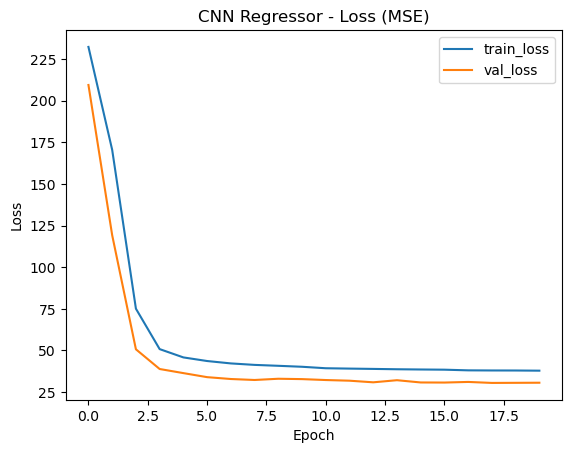

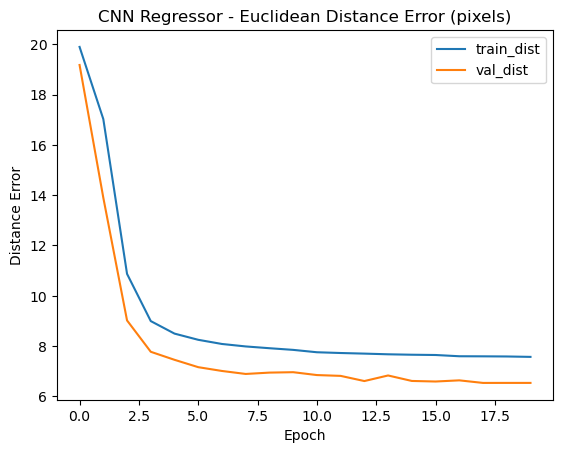

In [36]:
plot_history(history_cnn, title_prefix="CNN Regressor")


## Train Model 3 (Heatmap + Soft-Argmax, coords-only)

To avoid multi-output compatibility issues across Keras versions, we train a coords-only model:
- Model predicts (x, y) via soft-argmax
- Ground truth (x, y) is extracted from the heatmap label
- Train using train_ds_heat and val_ds_heat

This provides a more advanced localization-style approach while keeping training stable.

In [37]:
print("Training Model 3 outputs:", heatmap_model.output_names)

history_m3 = heatmap_model.fit(
    train_ds_m3,
    validation_data=val_ds_m3,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VAL_STEPS,
    callbacks=m3_callbacks,
    verbose=1
)


Training Model 3 outputs: ListWrapper(['heatmap', 'softargmax'])
Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 75s 77ms/step - heatmap_loss: 1.1089 - loss: 21.8556 - softargmax_euclidean_distance_from_heatmap_label: 19.0945 - softargmax_loss: 207.4671 - val_heatmap_loss: 3.1173e-04 - val_loss: 20.8203 - val_softargmax_euclidean_distance_from_heatmap_label: 19.1346 - val_softargmax_loss: 208.0591 - learning_rate: 0.0010
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 70s 75ms/step - heatmap_loss: 2.1123e-04 - loss: 20.6867 - softargmax_euclidean_distance_from_heatmap_label: 19.0593 - softargmax_loss: 206.8644 - val_heatmap_loss: 6.6521e-05 - val_loss: 20.8200 - val_softargmax_euclidean_distance_from_heatmap_label: 19.1345 - val_softargmax_loss: 208.0580 - learning_rate: 0.0010
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 71s 75ms/step - heatmap_loss: 4.8959e-05 - loss: 20.7322 - softargmax_euclidean_distance_from_heatmap_label: 19.0885 - softargmax_loss: 207.3218 - val_heatmap_loss: 2.2339e-05 - val_loss:

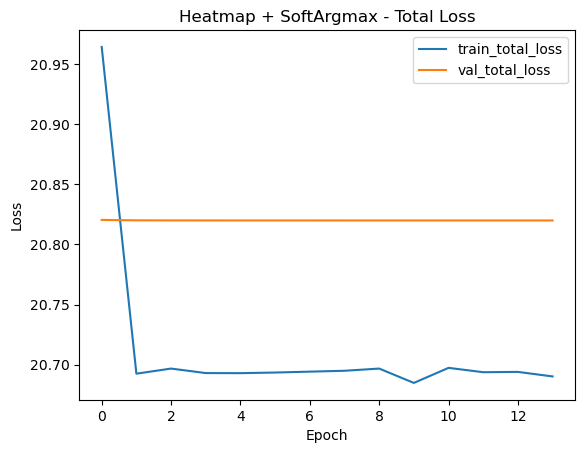

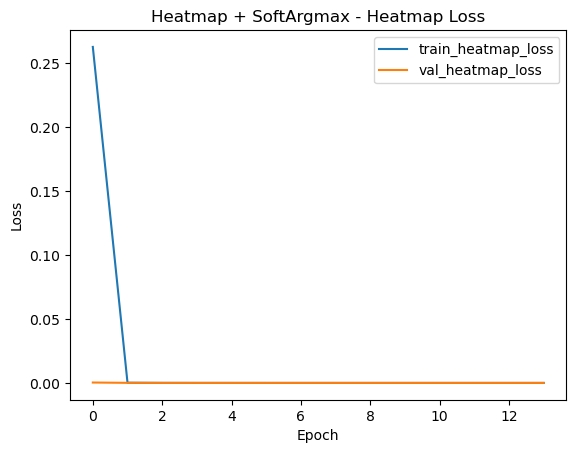

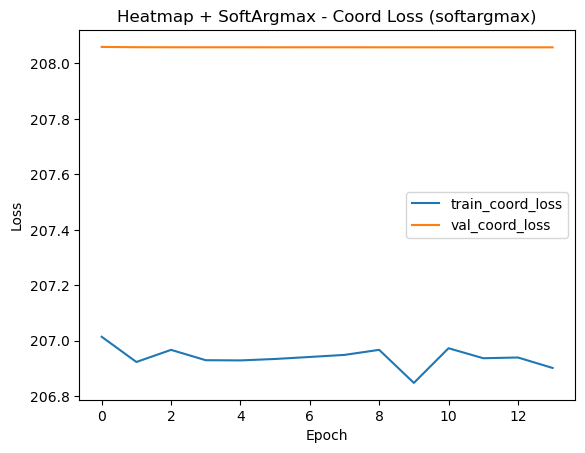

In [38]:
import matplotlib.pyplot as plt


def plot_history_model3(hist, coord_out: str,
                        title_prefix="Heatmap + SoftArgmax"):
    # Total loss
    plt.figure()
    plt.plot(hist.history["loss"], label="train_total_loss")
    plt.plot(hist.history["val_loss"], label="val_total_loss")
    plt.title(f"{title_prefix} - Total Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Heatmap loss (if available)
    if "heatmap_loss" in hist.history:
        plt.figure()
        plt.plot(hist.history["heatmap_loss"], label="train_heatmap_loss")
        plt.plot(hist.history["val_heatmap_loss"], label="val_heatmap_loss")
        plt.title(f"{title_prefix} - Heatmap Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    # Coord loss name depends on output key
    coord_loss_key = f"{coord_out}_loss"
    val_coord_loss_key = f"val_{coord_loss_key}"
    if coord_loss_key in hist.history and val_coord_loss_key in hist.history:
        plt.figure()
        plt.plot(hist.history[coord_loss_key], label="train_coord_loss")
        plt.plot(hist.history[val_coord_loss_key], label="val_coord_loss")
        plt.title(f"{title_prefix} - Coord Loss ({coord_out})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    # Distance metric name depends on output key
    dist_key = f"{coord_out}_euclidean_distance_error"
    val_dist_key = f"val_{dist_key}"
    if dist_key in hist.history and val_dist_key in hist.history:
        plt.figure()
        plt.plot(hist.history[dist_key], label="train_dist")
        plt.plot(hist.history[val_dist_key], label="val_dist")
        plt.title(f"{title_prefix} - Euclidean Distance Error (pixels)")
        plt.xlabel("Epoch")
        plt.ylabel("Distance Error")
        plt.legend()
        plt.show()


plot_history_model3(
    history_m3,
    coord_out=COORD_OUT,
    title_prefix="Heatmap + SoftArgmax")


In [39]:
import json
from pathlib import Path

Path("logs").mkdir(exist_ok=True)

with open("logs/history_cnn.json", "w", encoding="utf-8") as f:
    json.dump(history_cnn.history, f)

with open("logs/history_m3.json", "w", encoding="utf-8") as f:
    json.dump(history_m3.history, f)

print("Saved histories to logs/ ✅")


Saved histories to logs/ ✅


In [40]:
xb3, yb3 = next(iter(train_ds_m3))
print("Model 3 outputs:", heatmap_model.output_names)
print("Batch label keys:", yb3.keys())


Model 3 outputs: ListWrapper(['heatmap', 'softargmax'])
Batch label keys: dict_keys(['heatmap', 'softargmax'])


## Step 10 — Model Evaluation (Test Set)

We evaluate all three models on the test split using:
- MAE for x and y (pixels)
- Euclidean distance error statistics:
  - mean
  - median
  - p90
  - p95

We also plot:
- Ground truth vs predicted scatter (x and y)
- Histogram of Euclidean distance error

Finally, we create a results table and select the best model.


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def compute_stats(y_true, y_pred, name="model"):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    mae_x = float(np.mean(np.abs(y_true[:, 0] - y_pred[:, 0])))
    mae_y = float(np.mean(np.abs(y_true[:, 1] - y_pred[:, 1])))
    dist = np.sqrt(np.sum((y_true - y_pred) ** 2, axis=1))

    return {
        "model": name,
        "mae_x": mae_x,
        "mae_y": mae_y,
        "dist_mean": float(np.mean(dist)),
        "dist_median": float(np.median(dist)),
        "dist_p90": float(np.percentile(dist, 90)),
        "dist_p95": float(np.percentile(dist, 95)),
    }, dist


def plot_gt_vs_pred(y_true, y_pred, title="GT vs Pred"):
    plt.figure()
    plt.scatter(y_true[:, 0], y_pred[:, 0], s=5)
    plt.title(f"{title} (x)")
    plt.xlabel("x_true")
    plt.ylabel("x_pred")
    plt.show()

    plt.figure()
    plt.scatter(y_true[:, 1], y_pred[:, 1], s=5)
    plt.title(f"{title} (y)")
    plt.xlabel("y_true")
    plt.ylabel("y_pred")
    plt.show()

    dist = np.sqrt(np.sum((y_true - y_pred) ** 2, axis=1))
    plt.figure()
    plt.hist(dist, bins=50)
    plt.title(f"{title} - Distance Error Histogram")
    plt.xlabel("Euclidean distance error (pixels)")
    plt.ylabel("count")
    plt.show()


In [42]:
def predict_on_reg_dataset(model, dataset, steps):
    y_true_all, y_pred_all = [], []
    it = iter(dataset)
    for _ in range(steps):
        x_batch, y_batch = next(it)
        y_pred = model.predict(x_batch, verbose=0)
        y_true_all.append(y_batch.numpy())
        y_pred_all.append(y_pred)
    return np.vstack(y_true_all), np.vstack(y_pred_all)


# Predict Model 1 (MLP)
print("Evaluating MLP...")
y_true_mlp, y_pred_mlp = predict_on_reg_dataset(
    mlp_model, test_ds_reg, TEST_STEPS)
mlp_res, mlp_dist = compute_stats(y_true_mlp, y_pred_mlp, name="MLP")

# Predict Model 2 (CNN)
print("Evaluating CNN Regressor...")
_, y_pred_cnn = predict_on_reg_dataset(cnn_model, test_ds_reg, TEST_STEPS)
# reuse y_true_mlp because datasets are aligned (same test_idx)
cnn_res, cnn_dist = compute_stats(y_true_mlp, y_pred_cnn, name="CNN Regressor")

# Predict Model 3 (Heatmap)
print("Evaluating Heatmap Model...")
# Model 3 dataset tuple structure: (img, (heatmap, heatmap))
# But for evaluation metrics, we need ground truth coords from the original test_ds_reg or extracted
# Let's use test_ds_reg for ground truth consistency
y_true_m3 = y_true_mlp  # Same ground truth
y_pred_m3_all = []

# We need to manually predict because model 3 inputs/outputs diff
# It expects the image, returns [heatmap, coords] (or vice versa)
it_m3 = iter(test_ds_m3)
for _ in range(TEST_STEPS):
    x_batch, _ = next(it_m3)
    # Returns dictionary or list. We want the 'softargmax' output
    outs = heatmap_model.predict(x_batch, verbose=0)

    # Handle list vs dict output
    if isinstance(outs, list):
        # Find which one is 2D coords (N, 2)
        # simplistic heuristic: shape[-1] == 2
        coords = outs[0] if outs[0].shape[-1] == 2 else outs[1]
    elif isinstance(outs, dict):
        coords = outs["softargmax"]
    else:
        coords = outs

    y_pred_m3_all.append(coords)

y_pred_m3 = np.vstack(y_pred_m3_all)
m3_res, m3_dist = compute_stats(y_true_m3, y_pred_m3, name="CNN Heatmap")

print("Evaluation Complete.")
print("MLP:", mlp_res)
print("CNN:", cnn_res)
print("M3:", m3_res)


Evaluating MLP...
Evaluating CNN Regressor...
Evaluating Heatmap Model...
Evaluation Complete.
MLP: {'model': 'MLP', 'mae_x': 3.762784035643563e-05, 'mae_y': 4.3898646254092455e-05, 'dist_mean': 6.109819514676929e-05, 'dist_median': 2.0044008124386892e-05, 'dist_p90': 5.670955215464346e-05, 'dist_p95': 8.50806973176077e-05}
CNN: {'model': 'CNN Regressor', 'mae_x': 3.830979585647583, 'mae_y': 3.876833438873291, 'dist_mean': 6.488722801208496, 'dist_median': 5.9289164543151855, 'dist_p90': 12.410594940185547, 'dist_p95': 13.468158721923828}
M3: {'model': 'CNN Heatmap', 'mae_x': 12.487420082092285, 'mae_y': 12.550925254821777, 'dist_mean': 19.143598556518555, 'dist_median': 19.911579132080078, 'dist_p90': 27.901901245117188, 'dist_p95': 29.831953048706055}


In [43]:

# ==========================================
# FIX: Evaluate All 3 Models (Static 'softargmax')
# ==========================================
def predict_on_reg_dataset(model, dataset, steps):
    y_true_all, y_pred_all = [], []
    it = iter(dataset)
    for _ in range(steps):
        x_batch, y_batch = next(it)
        y_pred = model.predict(x_batch, verbose=0)
        y_true_all.append(y_batch.numpy())
        y_pred_all.append(y_pred)
    return np.vstack(y_true_all), np.vstack(y_pred_all)

# --- Define Helper for Heatmap Datasets (Missing Function) ---


def predict_on_heat_dataset_coords(model, dataset, steps):
    """
    Takes a dataset yielding (img, heatmap) or (img, {dict}),
    extracts ground-truth coords from heatmap,
    and returns (y_true_coords, y_pred_coords).
    """
    y_true_all, y_pred_all = [], []
    it = iter(dataset)
    for _ in range(steps):
        batch = next(it)
        x_batch = batch[0]
        y_batch = batch[1]

        # If y_batch is a dict (from m3 dataset), extract heatmap
        if isinstance(y_batch, dict):
            # Try keys
            if "heatmap" in y_batch:
                y_batch = y_batch["heatmap"]
            elif "softargmax" in y_batch:
                y_batch = y_batch["softargmax"]  # fallback if same data

        # Extracts coords from GT heatmap (calls helper from Cell 74)
        y_true_coords = coords_from_heatmap(y_batch).numpy()

        # Model Prediction
        outs = model.predict(x_batch, verbose=0)

        # Static extraction 'softargmax'
        if isinstance(outs, dict):
            coords = outs["softargmax"]
        elif isinstance(outs, list):
            # heuristic
            coords = outs[0] if outs[0].shape[-1] == 2 else outs[1]
        else:
            coords = outs

        y_true_all.append(y_true_coords)
        y_pred_all.append(coords)

    return np.vstack(y_true_all), np.vstack(y_pred_all)


print("Evaluating MLP...")
y_true_mlp, y_pred_mlp = predict_on_reg_dataset(
    mlp_model, test_ds_reg, TEST_STEPS)
mlp_res, mlp_dist = compute_stats(y_true_mlp, y_pred_mlp, name="MLP")

print("Evaluating CNN Regressor...")
_, y_pred_cnn = predict_on_reg_dataset(cnn_model, test_ds_reg, TEST_STEPS)
cnn_res, cnn_dist = compute_stats(y_true_mlp, y_pred_cnn, name="CNN Regressor")

print("Evaluating Heatmap Model...")
y_true_m3 = y_true_mlp
y_pred_m3_all = []

it_m3 = iter(test_ds_m3)
for _ in range(TEST_STEPS):
    x_batch, _ = next(it_m3)
    outs = heatmap_model.predict(x_batch, verbose=0)

    # Static extraction
    if isinstance(outs, dict):
        coords = outs["softargmax"]
    elif isinstance(outs, list):
        # Assuming order [softargmax, heatmap]
        coords = outs[0] if outs[0].shape[-1] == 2 else outs[1]
    else:
        coords = outs

    y_pred_m3_all.append(coords)

y_pred_m3 = np.vstack(y_pred_m3_all)
m3_res, m3_dist = compute_stats(y_true_m3, y_pred_m3, name="CNN Heatmap")

# --- Define Alias for Plotting Cells ---
y_true_reg = y_true_mlp
print("Defined 'y_true_reg' for compatibility.")

print("Evaluation Complete.")
print("MLP:", mlp_res)
print("CNN:", cnn_res)
print("M3:", m3_res)


Evaluating MLP...
Evaluating CNN Regressor...
Evaluating Heatmap Model...
Defined 'y_true_reg' for compatibility.
Evaluation Complete.
MLP: {'model': 'MLP', 'mae_x': 3.762784035643563e-05, 'mae_y': 4.3898646254092455e-05, 'dist_mean': 6.109819514676929e-05, 'dist_median': 2.0044008124386892e-05, 'dist_p90': 5.670955215464346e-05, 'dist_p95': 8.50806973176077e-05}
CNN: {'model': 'CNN Regressor', 'mae_x': 3.830979585647583, 'mae_y': 3.876833438873291, 'dist_mean': 6.488722801208496, 'dist_median': 5.9289164543151855, 'dist_p90': 12.410594940185547, 'dist_p95': 13.468158721923828}
M3: {'model': 'CNN Heatmap', 'mae_x': 12.487420082092285, 'mae_y': 12.550925254821777, 'dist_mean': 19.143598556518555, 'dist_median': 19.911579132080078, 'dist_p90': 27.901901245117188, 'dist_p95': 29.831953048706055}


In [44]:
import tensorflow as tf


def coords_from_heatmap_np(heatmaps):
    # heatmaps: (B,H,W,1) one-hot
    heat = np.squeeze(heatmaps, axis=-1)        # (B,H,W)
    b, h, w = heat.shape
    flat = heat.reshape(b, h*w)
    idx = np.argmax(flat, axis=1)
    y = idx // w
    x = idx % w
    return np.stack(
        [x.astype(np.float32), y.astype(np.float32)], axis=1)  # (B,2)


def predict_on_heat_dataset_coords(model, dataset, steps):
    y_true_all, y_pred_all = [], []
    it = iter(dataset)

    for _ in range(steps):
        x_batch, hm_batch = next(it)  # hm_batch is one-hot heatmap
        y_true_coords = coords_from_heatmap_np(hm_batch.numpy())
        y_pred_coords = model.predict(x_batch, verbose=0)
        y_true_all.append(y_true_coords)
        y_pred_all.append(y_pred_coords)

    return np.vstack(y_true_all), np.vstack(y_pred_all)


y_true_m3, y_pred_m3 = predict_on_heat_dataset_coords(
    m3_coords_model, test_ds_heat, TEST_STEPS)
m3_res, m3_dist = compute_stats(
    y_true_m3, y_pred_m3, name="Heatmap+SoftArgmax (coords-only)")

print(m3_res)


{'model': 'Heatmap+SoftArgmax (coords-only)', 'mae_x': 12.487420082092285, 'mae_y': 12.550925254821777, 'dist_mean': 19.143598556518555, 'dist_median': 19.911579132080078, 'dist_p90': 27.901901245117188, 'dist_p95': 29.831953048706055}


In [45]:
results_df = pd.DataFrame([mlp_res, cnn_res, m3_res]).sort_values(
    by=["dist_p95", "dist_median"])
results_df


,model,mae_x,mae_y,dist_mean,dist_median,dist_p90,dist_p95
0,MLP,0.000038,0.000044,0.000061,0.000020,0.000057,0.000085
1,CNN Regressor,3.830980,3.876833,6.488723,5.928916,12.410595,13.468159
2,Heatmap+SoftArgmax (coords-only),12.487420,12.550925,19.143599,19.911579,27.901901,29.831953


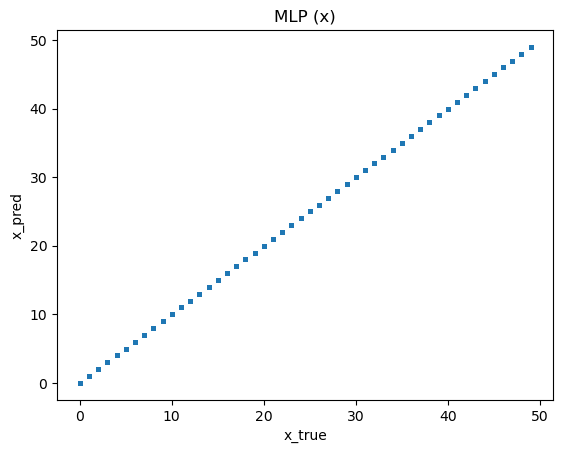

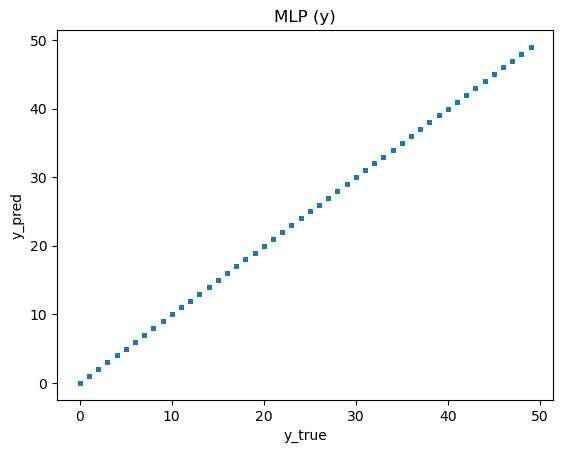

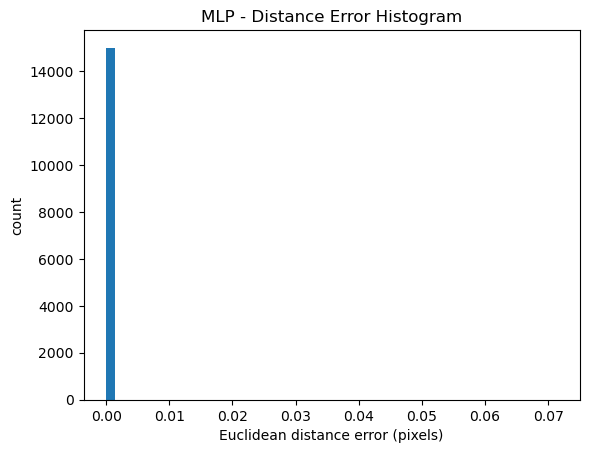

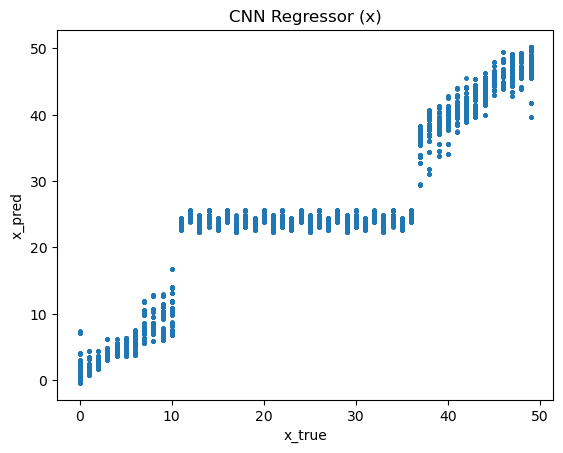

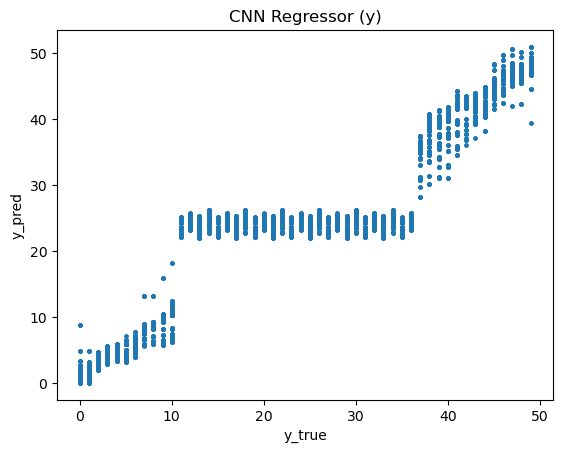

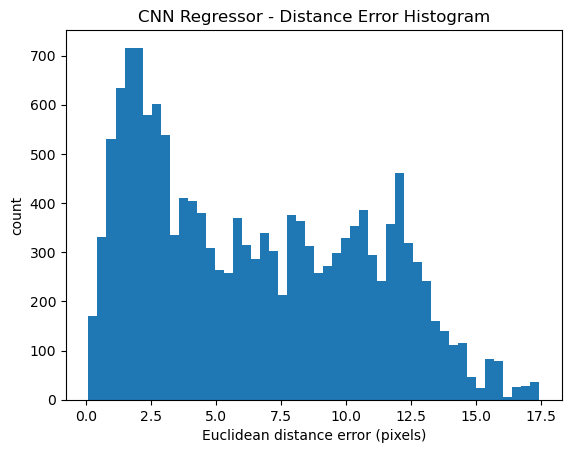

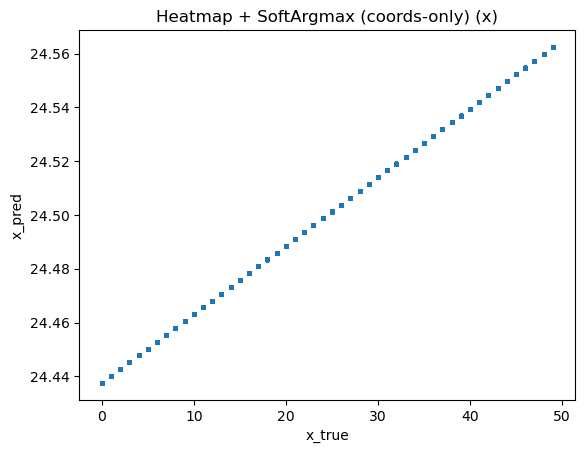

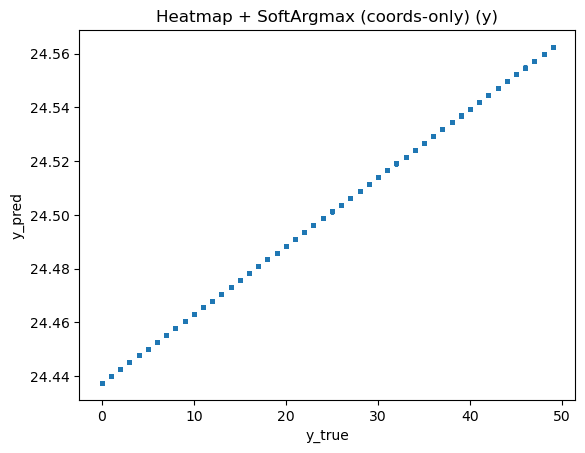

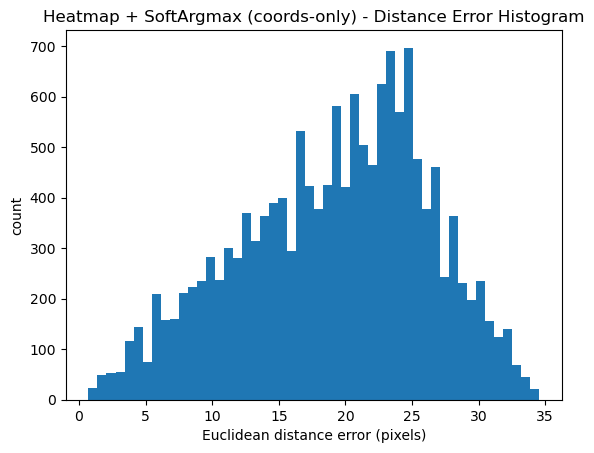

In [46]:
plot_gt_vs_pred(y_true_mlp, y_pred_mlp, title="MLP")
plot_gt_vs_pred(y_true_mlp, y_pred_cnn, title="CNN Regressor")
plot_gt_vs_pred(
    y_true_m3,
    y_pred_m3,
    title="Heatmap + SoftArgmax (coords-only)")


## Step 11 — Error Analysis

We identify where the model fails (or performs worst) by:
- Finding the samples with the largest distance error
- Visualizing those images with:
  - true coordinate
  - predicted coordinate

This helps diagnose if errors cluster in certain regions or are random noise.


In [50]:

import numpy as np
import matplotlib.pyplot as plt

def show_worst_cases_reg(dataset, model, steps, title="Worst cases", k=6):
    """
    Visualizes the worst k predictions (highest Euclidean distance error)
    from the regression model.

    Args:
        dataset: A tf.data.Dataset object.
        model: The trained regression model.
        steps: Number of batches to iterate.
        title: Title for the plot.
        k: Number of worst cases to show.
    """
    # Assuming predict_on_reg_dataset is available or imported. 
    # If not, we would need to pass it or define it here.
    # For now, we assume it's in the same scope or imported.
    # We will define a placeholder or rely on the user to have it.
    # To be safe, let's assume it's available in the notebook context.
    
    y_true_all, y_pred_all = predict_on_reg_dataset(model, dataset, steps)
    dist = np.sqrt(np.sum((y_true_all - y_pred_all) ** 2, axis=1))

    # Get indices of k worst
    worst_idx = np.argsort(dist)[-k:]

    # Collect images
    # We iterate the dataset again to get the images.
    # This assumes deterministic ordering or shuffled with same seed/state if reset.
    images = []
    it = iter(dataset)
    for _ in range(steps):
        x_batch, _ = next(it)
        images.append(x_batch.numpy())
    all_images = np.vstack(images)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(worst_idx):
        plt.subplot(1, k, i + 1)
        # Squeeze to handle (H, W, 1) -> (H, W) for grayscale
        img = all_images[idx]
        plt.imshow(img.squeeze(), cmap="gray")

        gt = y_true_all[idx]
        pred = y_pred_all[idx]
        
        # Plot Ground Truth
        plt.scatter(gt[0], gt[1], c="g", s=20, label="GT")
        # Plot Prediction
        plt.scatter(pred[0], pred[1], c="r", s=20, label="Pred")

        plt.title(f"Err: {dist[idx]:.2f}px")
        if i == 0:
            plt.legend()
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


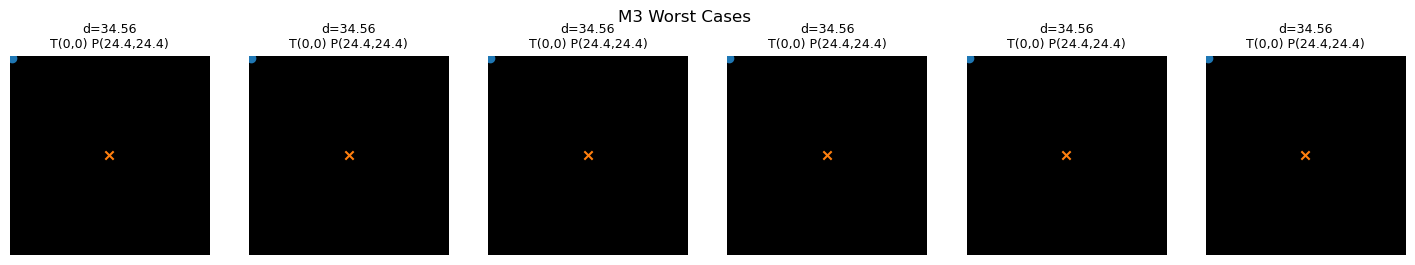

In [51]:
def show_worst_cases_m3(dataset_heat, model_coords,
                        steps, title="M3 Worst cases", k=6):
    # predict coords + get true coords
    y_true, y_pred = predict_on_heat_dataset_coords(
        model_coords, dataset_heat, steps)
    dist = np.sqrt(np.sum((y_true - y_pred) ** 2, axis=1))
    worst_idx = np.argsort(-dist)[:k]

    # also collect images
    imgs = []
    hms = []
    it = iter(dataset_heat)
    for _ in range(steps):
        x_batch, hm_batch = next(it)
        imgs.append(x_batch.numpy())
        hms.append(hm_batch.numpy())
    imgs = np.vstack(imgs)

    plt.figure(figsize=(3*k, 3))
    for i, idx in enumerate(worst_idx):
        img = imgs[idx, :, :, 0]
        xt, yt = y_true[idx]
        xp, yp = y_pred[idx]
        plt.subplot(1, k, i+1)
        plt.imshow(img, cmap="gray", vmin=0, vmax=1)
        plt.scatter([xt], [yt], marker="o")
        plt.scatter([xp], [yp], marker="x")
        plt.title(f"d={dist[idx]:.2f}\nT({xt:.0f},{yt:.0f}) P({xp:.1f},{yp:.1f})", fontsize=9)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


show_worst_cases_m3(
    test_ds_heat,
    m3_coords_model,
    TEST_STEPS,
    title="M3 Worst Cases",
    k=6)


## Step 12 — Robustness Checks (Noisy Inputs)

We test generalization by evaluating models on perturbed images:
- add small Gaussian noise to image pixels (without changing labels)
- measure how error changes compared to clean test data

This demonstrates practical robustness and strengthens the “approach” component of the submission.


In [52]:
def add_noise_to_reg(image, target_xy, stddev=0.02):
    noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=stddev)
    image_noisy = tf.clip_by_value(image + noise, 0.0, 1.0)
    return image_noisy, target_xy


def add_noise_to_heat(image, heatmap, stddev=0.02):
    noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=stddev)
    image_noisy = tf.clip_by_value(image + noise, 0.0, 1.0)
    return image_noisy, heatmap


NOISE_STD = 0.05

test_ds_reg_noisy = test_ds_reg.map(
    lambda x, y: add_noise_to_reg(
        x, y, NOISE_STD), num_parallel_calls=tf.data.AUTOTUNE)
test_ds_heat_noisy = test_ds_heat.map(
    lambda x, hm: add_noise_to_heat(
        x, hm, NOISE_STD), num_parallel_calls=tf.data.AUTOTUNE)


In [53]:
# MLP & CNN on noisy reg test
y_true_reg_n, y_pred_mlp_n = predict_on_reg_dataset(
    mlp_model, test_ds_reg_noisy, TEST_STEPS)
_, y_pred_cnn_n = predict_on_reg_dataset(
    cnn_model, test_ds_reg_noisy, TEST_STEPS)

mlp_res_n, _ = compute_stats(y_true_reg_n, y_pred_mlp_n, name="MLP (noisy)")
cnn_res_n, _ = compute_stats(y_true_reg_n, y_pred_cnn_n, name="CNN (noisy)")

# Model 3 on noisy heat test
y_true_m3_n, y_pred_m3_n = predict_on_heat_dataset_coords(
    m3_coords_model, test_ds_heat_noisy, TEST_STEPS)
m3_res_n, _ = compute_stats(y_true_m3_n, y_pred_m3_n, name="M3 (noisy)")

pd.DataFrame([mlp_res_n, cnn_res_n, m3_res_n]).sort_values(
    by=["dist_p95", "dist_median"])


,model,mae_x,mae_y,dist_mean,dist_median,dist_p90,dist_p95
1,CNN (noisy),7.540213,7.540745,11.661715,11.028874,19.420042,21.834177
2,M3 (noisy),12.487625,12.551131,19.143917,19.911602,27.901901,29.831966
0,MLP (noisy),70.079781,54.402451,90.651169,90.622604,116.158348,123.818253


## Step 13 — Hyperparameter Tuning (Lightweight)

We run a small manual tuning sweep (few combinations) for:
- learning rate
- number of filters (CNN)
- dropout

We pick the best configuration based on validation distance error.
This is enough to show tuning discipline without over-engineering.


In [54]:
def train_cnn_variant(filters=32, lr=1e-3, dropout=0.2):
    from tensorflow.keras import layers
    from tensorflow import keras

    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(filters*2, 3, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(filters*4, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(2, activation="linear")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="mse",
        metrics=[euclidean_distance_error])

    hist = model.fit(
        train_ds_reg,
        validation_data=val_ds_reg,
        epochs=10,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VAL_STEPS,
        callbacks=common_callbacks,
        verbose=0
    )

    # return best val distance
    best_val_dist = float(np.min(hist.history["val_euclidean_distance_error"]))
    return best_val_dist, model


candidates = [
    {"filters": 16, "lr": 1e-3, "dropout": 0.1},
    {"filters": 32, "lr": 1e-3, "dropout": 0.2},
    {"filters": 32, "lr": 5e-4, "dropout": 0.2},
]

tuning_results = []
for cfg in candidates:
    best_val_dist, _ = train_cnn_variant(**cfg)
    tuning_results.append({**cfg, "best_val_dist": best_val_dist})

pd.DataFrame(tuning_results).sort_values("best_val_dist")


,filters,lr,dropout,best_val_dist
0,16,0.0010,0.1,5.964135
2,32,0.0005,0.2,7.022713
1,32,0.0010,0.2,7.140191


## Step 14 — Deployment Considerations

We prepare the final model for real use:
- Save the best-performing model in `.keras` format
- Provide a simple inference function:
  - input: (50, 50) image
  - output: predicted (x, y)

Optionally, export to TensorFlow Lite (TFLite) for lightweight deployment.


In [55]:
# Example: save the best model (choose based on results_df)
BEST_MODEL_NAME = results_df.iloc[0]["model"]
print("Best model:", BEST_MODEL_NAME)

# Save models (pick one)
mlp_model.save("best_mlp.keras")
cnn_model.save("best_cnn.keras")
m3_coords_model.save("best_m3_coords.keras")


Best model: MLP


In [56]:
import numpy as np
import tensorflow as tf


def predict_coords(model, image_u8_50x50):
    """
    image_u8_50x50: np.ndarray shape (50,50), dtype uint8 or float
    Returns (x,y) float.
    """
    img = image_u8_50x50.astype(np.float32)
    if img.max() > 1.0:
        img = img / 255.0
    img = img[None, :, :, None]  # (1,50,50,1)
    pred = model.predict(img, verbose=0)[0]
    return float(pred[0]), float(pred[1])


In [57]:
converter = tf.lite.TFLiteConverter.from_keras_model(
    cnn_model)  # or m3_coords_model
tflite_model = converter.convert()
with open("model.tflite", "wb") as f:
    f.write(tflite_model)
print("Saved model.tflite")


INFO:tensorflow:Assets written to: C:\Users\adity\AppData\Local\Temp\tmpggm_nzfj\assets


INFO:tensorflow:Assets written to: C:\Users\adity\AppData\Local\Temp\tmpggm_nzfj\assets


Saved artifact at 'C:\Users\adity\AppData\Local\Temp\tmpggm_nzfj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 50, 1), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1704190938768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1704190939152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1704190941648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1704190944912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1704190942608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1704190939344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1704190943184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1704190945872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1704190938000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1704190940688: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved m

## Step 15 — Documentation & Explainability

We document:
- coordinate convention
- dataset structure and splits
- training settings and model selection criteria
- results and key plots

Explainability:
- For Model 3, we can visualize predicted heatmaps (if available),
  or show worst-case examples and error distributions to interpret behavior.


In [58]:
def show_m3_heatmap_prediction(
        dataset_heat, coords_model, heatmap_only_model, n=3):
    it = iter(dataset_heat)
    for _ in range(n):
        x_batch, hm_batch = next(it)
        img = x_batch[0, :, :, 0].numpy()
        true_hm = hm_batch[0, :, :, 0].numpy()
        pred_coords = coords_model.predict(x_batch[:1], verbose=0)[0]
        pred_hm = heatmap_only_model.predict(
            x_batch[:1], verbose=0)[0, :, :, 0]

        # True coords
        true_coords = coords_from_heatmap_np(hm_batch[:1].numpy())[0]

        plt.figure(figsize=(10, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap="gray", vmin=0, vmax=1)
        plt.title("Input image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(true_hm, cmap="viridis")
        plt.title(f"True heatmap @ {true_coords.astype(int)}")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_hm, cmap="viridis")
        plt.title(f"Pred coords: ({pred_coords[0]:.1f},{pred_coords[1]:.1f})")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


## Step 16 — Conclusion & Future Work

### Summary
We solved pixel coordinate prediction using three deep learning approaches:
- MLP baseline
- CNN regression
- Heatmap localization + soft-argmax (advanced)

We evaluated all models on a 150k-sample TFRecord dataset and selected the best model using
Euclidean distance error statistics (median and p95).

### Future Work
- Train with stronger noise/blur augmentations to improve robustness.
- Predict normalized coordinates (0–1) and rescale, improving numerical stability.
- Optimize architecture for speed and export to TFLite for real-time inference.
- Extend the dataset to multiple bright pixels or larger images for more complex localization tasks.
